In [2]:
# Standard Imports
import numpy as np
from time import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Circle as pltCircle
from matplotlib.collections import PathCollection
from random import choices
from imageio import imread




# SHAPER
from src.Observables import Observable
from src.CommonObservables import NSubjettiness
from src.Shaper import Shaper
from src.Manifolds import Coordinates2D, Simplex, PositiveReals

import torch 
import torch.nn as nn



# Utils
from utils.data_utils import load_cmsopendata
from utils.plot_utils import plot_event

# Jets
from pyjet import cluster


# GPU nonsense
if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 



Using CPU!


In [3]:


# Parameters
R = 0.5
beta = 1.0
N = 50
batch_size = min(5000,N)
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"

# cms, cms_weights = load_cmsopendata("data", "cms", pt_lower, pt_upper, eta, quality, pad, n = N, amount = 1)
# sim, sim_weights, sim_factors = load_cmsopendata("data", "sim", pt_lower, pt_upper, eta, quality, pad, n = N, amount = 1)

In [4]:
def squarify(M,val):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)



def load_image(fname):
    img = imread(fname, as_gray=True)  # Grayscale
    img = (img[::-1,:]) / 255.0
    mask = img > 0
    img[mask] = 1
    img = squarify(img,0)
    plt.imshow(img)
    plt.show()
    return img

fname = "BOOST.png"
def boost_samples(n, param_dict, dtype=torch.FloatTensor):
    A = load_image(fname)
    xg, yg = np.meshgrid(
        np.linspace(-0.5, 0.5, A.shape[0]),
        np.linspace(0.0, 0.5, A.shape[1]),
        indexing="xy",
    )


    print(A.shape)
    grid = list(zip(xg.ravel(), yg.ravel()))
    dens = A.ravel() / A.sum()
    dots = np.array(choices(grid, dens, k=n))
    print(sum(dens))
    # dots += (0.5 / A.shape[0]) * np.random.standard_normal(dots.shape)

    return (dots, np.ones((n,)) / n)


def display_samples(x, color = "red"):
    plt.scatter(x[:, 0], x[:, 1], 25 * 500 / len(x), color = 'black', edgecolors="none")
    plt.show()


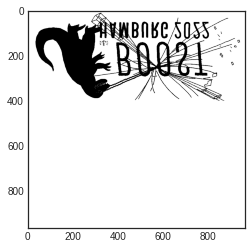

(966, 966)
1.000000011764314


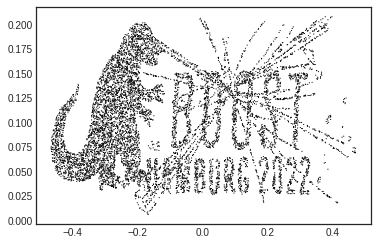

In [5]:
fig, ax = plt.subplots()


x, z = boost_samples(10000, {})
display_samples(x)
plt.show()

event = (x, z)
events = (event,)


In [6]:
# Sample at N weighted Dirac deltas
def point_sampler(N, param_dict):
    return (param_dict["Points"].params.to(device), param_dict["Weights"].params.to(device))


def point_plotter(ax, param_dict):

    points = param_dict["Points"].params.clone().detach().numpy()
    weights = param_dict["Weights"].params.clone().detach().numpy()


    # Center
    ax.scatter(points[:,0], points[:,1], color = "Purple", label = "Subjet", marker = "o", s = 2 * weights * 15500/np.sum(weights), alpha = 0.25)
    


N = 250
_25subjettiness = Observable({"Points" : Coordinates2D(25, R = 0.05), "Weights" : Simplex(25)}, point_sampler, plotter = point_plotter, beta = 1, R = 0.25)
_250subjettiness = Observable({"Points" : Coordinates2D(250, R = 0.05), "Weights" : Simplex(250)}, point_sampler, plotter = point_plotter, beta = 1, R = 0.25)
_2500subjettiness = Observable({"Points" : Coordinates2D(2500, R = 0.05), "Weights" : Simplex(2500)}, point_sampler, plotter = point_plotter, beta = 1, R = 0.25)

shaper = Shaper({"25-Subjettiness"  : _25subjettiness, "250-Subjettiness"  : _250subjettiness, "2500-Subjettiness"  : _2500subjettiness,})
shaper.to(device)

signal_emds, signal_params = shaper.calculate(events, epochs = 500, verbose=True, lr = 0.01, scaling = 0.5, epsilon = 0.001, early_stopping= 25, plot_directory="BOOST", gif_directory="BOOST", N = 5000)


Created Directory: BOOST/25-Subjettiness
Observable: 25-Subjettiness Epoch 0 Mean Loss = 0.2207859456539154 Elapsed time = 10.150s Percentage done = 0.000 
Observable: 25-Subjettiness Epoch 1 Mean Loss = 0.20827093720436096 Elapsed time = 18.502s Percentage done = 0.000 
Observable: 25-Subjettiness Epoch 2 Mean Loss = 0.19580405950546265 Elapsed time = 27.113s Percentage done = 0.000 
Observable: 25-Subjettiness Epoch 3 Mean Loss = 0.18367139995098114 Elapsed time = 43.055s Percentage done = 0.000 
Observable: 25-Subjettiness Epoch 4 Mean Loss = 0.17183847725391388 Elapsed time = 75.394s Percentage done = 0.000 
Observable: 25-Subjettiness Epoch 5 Mean Loss = 0.1603710949420929 Elapsed time = 104.132s Percentage done = 0.000 
Observable: 25-Subjettiness Epoch 6 Mean Loss = 0.1495463103055954 Elapsed time = 132.276s Percentage done = 0.000 
Observable: 25-Subjettiness Epoch 7 Mean Loss = 0.13924874365329742 Elapsed time = 150.633s Percentage done = 0.000 
Observable: 25-Subjettiness Epo

In [7]:
def plot_observable(param_dict, title, R, filename = None, color = "red"):

    fig, ax = plt.subplots(constrained_layout=True, figsize = (24,6))
    
    points = param_dict["Points"].params.clone().detach().numpy()
    weights = param_dict["Weights"].params.clone().detach().numpy()


    # Center
    ax.scatter(points[:,0], points[:,1], color = "Purple", label = "Subjet", marker = "o", s = 2 * weights * 15500/np.sum(weights), alpha = 0.25)
    

    # Legend 
    legend = plt.legend(loc=(0.1, 1.0), frameon=False, ncol=3, handletextpad=0)
    legend.legendHandles[0]._sizes = [50]
    try:
        legend.legendHandles[1]._sizes = [50]
    except:
        pass


    # plot settings
    plt.title(title, loc = "right")
    plt.xlim(-R*1.25, R*1.25); plt.ylim(-R*1.25, R*1.25)
    plt.xlim(-0.5, 0.5); plt.ylim(0, .25)
    plt.xlabel('Rapidity'); plt.ylabel('Azimuthal Angle')
    # plt.xticks(np.linspace(-R, R, 5)); plt.yticks(np.linspace(-R, R, 5))


    ax.set_aspect('equal')
    if filename:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()

In [10]:
observables = {"25-Subjettiness"  : _25subjettiness, "250-Subjettiness"  : _250subjettiness, "2500-Subjettiness"  : _2500subjettiness,}
for obs in observables:

    param_dict = signal_params[obs][0]
    plot_observable(param_dict, obs, R, "%s" % obs + ".png")